In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cluster import distance_values
from Bio import SeqIO
from Bio import Phylo
from showHOR import show_hor, show_hors, show_hor_tree
from featureUtils import BED_file_to_features, feature_to_seq, remove_overlapping_features
from parallel_distance import build_seqs_distance_matrix_by_chunks, FileSystemChunkStore
from hor import hor_tree_to_phylogeny
from hor_tree import phylogeny_to_hor_tree
from Bio.Phylo.PhyloXML import Phyloxml
from Bio.Phylo import PhyloXMLIO
from clustering_to_phylogeny import clustering_to_phylogeny



In [2]:
references = {seq.id : seq for seq in SeqIO.parse("./data/fileschr4chimp/chimpH2.chr4.fasta", "fasta")}

In [3]:
monomers_as_features = BED_file_to_features("./data/fileschr4chimp/final_decomposition.bed")

In [4]:
monomers_as_features = remove_overlapping_features(
    features=monomers_as_features,
    expected_feature_size=107,
    max_allowed_overlap_fraction=0.25
)

Kept sequence feature chr4_hap2_hsa5:64806450-67061718[80169:80343](+) overlapping (10 bps) with sequence feature chr4_hap2_hsa5:64806450-67061718[80042:80179](+).
Removed sequence feature chr4_hap2_hsa5:64806450-67061718[345135:345304](+) overlapping (50 bps) with sequence feature chr4_hap2_hsa5:64806450-67061718[345034:345185](+).
Kept sequence feature chr4_hap2_hsa5:64806450-67061718[2150195:2150277](+) overlapping (3 bps) with sequence feature chr4_hap2_hsa5:64806450-67061718[2150026:2150198](+).


In [5]:
# sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 60
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [6]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [7]:
monomer_dists = build_seqs_distance_matrix_by_chunks(monomers_as_seqs, num_chunks=32, chunk_store=FileSystemChunkStore("data/fileschr4chimp/submatrices_32/piece_{row}_{col}"))

# of chunks for computing distance matrix: 32
Chunk size: 390
Num processes: 512
Blocks: ['([0:1](390,390))', '([0:2](390,390))', '([1:2](390,390))', '([0:3](390,390))', '([1:3](390,390))', '([2:3](390,390))', '([0:4](390,390))', '([1:4](390,390))', '([2:4](390,390))', '([3:4](390,390))', '([0:5](390,390))', '([1:5](390,390))', '([2:5](390,390))', '([3:5](390,390))', '([4:5](390,390))', '([0:6](390,390))', '([1:6](390,390))', '([2:6](390,390))', '([3:6](390,390))', '([4:6](390,390))', '([5:6](390,390))', '([0:7](390,390))', '([1:7](390,390))', '([2:7](390,390))', '([3:7](390,390))', '([4:7](390,390))', '([5:7](390,390))', '([6:7](390,390))', '([0:8](390,390))', '([1:8](390,390))', '([2:8](390,390))', '([3:8](390,390))', '([4:8](390,390))', '([5:8](390,390))', '([6:8](390,390))', '([7:8](390,390))', '([0:9](390,390))', '([1:9](390,390))', '([2:9](390,390))', '([3:9](390,390))', '([4:9](390,390))', '([5:9](390,390))', '([6:9](390,390))', '([7:9](390,390))', '([8:9](390,390))', '([0:10](3

ValueError: Mismatched array shapes in block along axis 1.

In [ ]:
with open('data/fileschr4chimp/distances.npy', 'wb') as f:
    np.save(f, monomer_dists)

(array([2.027830e+05, 4.627350e+05, 7.656430e+05, 1.042713e+06,
        1.175023e+06, 1.093469e+06, 9.091860e+05, 6.984620e+05,
        4.955850e+05, 3.621580e+05, 2.560060e+05, 1.810190e+05,
        1.427480e+05, 1.311910e+05, 1.176490e+05, 1.086730e+05,
        8.778500e+04, 5.738100e+04, 3.942000e+04, 3.245400e+04,
        2.695200e+04, 2.557800e+04, 3.517000e+04, 5.034500e+04,
        6.272800e+04, 6.621200e+04, 7.068700e+04, 8.902900e+04,
        1.101610e+05, 1.337310e+05, 1.804470e+05, 2.562790e+05,
        4.447050e+05, 8.186010e+05, 1.331432e+06, 1.747583e+06,
        1.866810e+06, 1.830840e+06, 1.710382e+06, 1.553249e+06,
        1.504898e+06, 1.543269e+06, 1.726926e+06, 1.821598e+06,
        1.824416e+06, 2.096476e+06, 2.546656e+06, 2.849715e+06,
        3.126334e+06, 3.126800e+06, 2.824746e+06, 2.571960e+06,
        2.116858e+06, 1.521218e+06, 1.112044e+06, 8.371780e+05,
        6.277610e+05, 5.087340e+05, 4.367740e+05, 3.768250e+05,
        3.351390e+05, 2.899520e+05, 2.49

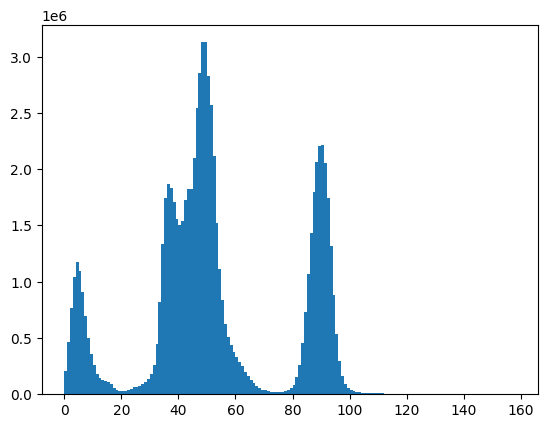

In [ ]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))


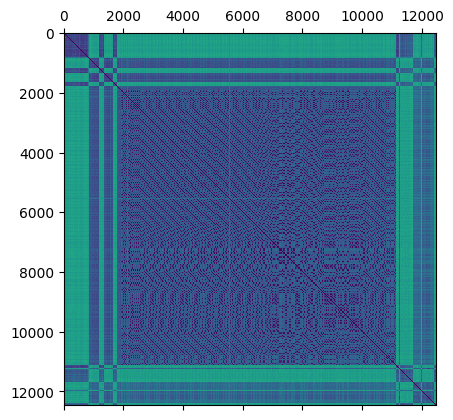

In [ ]:
plt.matshow(monomer_dists)

In [ ]:
clustering_res = clustering_to_phylogeny(
    dist_matrix=monomer_dists,
    items_as_seq_features=monomers_as_features,
    seq_references=references
)
phylogeny = clustering_res.phylogeny

In [ ]:
phyloXml = Phyloxml(phylogenies=[phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/fileschr4chimp/monomer_phylogeny.xml')

1

In [ ]:
hor_tree_root = phylogeny_to_hor_tree(phylogeny, min_loops=5, allow_hor_overlap=False)

In [ ]:
hor_phylogeny = hor_tree_to_phylogeny(hor_tree_root)

/Users/miguel/git/dna-repeat-discovery/env/lib/python3.11/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [ ]:
phyloXml = Phyloxml(phylogenies=[hor_phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/fileschr4chimp/HORs.xml')

1

In [ ]:
phyloXml = Phyloxml(phylogenies=[phylogeny, hor_phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/fileschr4chimp/monomer_phylogeny_and_HORs.xml')

2

In [ ]:
references['chr4_hap2_hsa5:64806450-67061718']

SeqRecord(seq=Seq('TATCACCTGAGGTCAAGAGTTCAAGACCAGCCTGGCCAACATGGTGAAAACTCA...ACT'), id='chr4_hap2_hsa5:64806450-67061718', name='chr4_hap2_hsa5:64806450-67061718', description='chr4_hap2_hsa5:64806450-67061718', dbxrefs=[])

Subtree: []
None


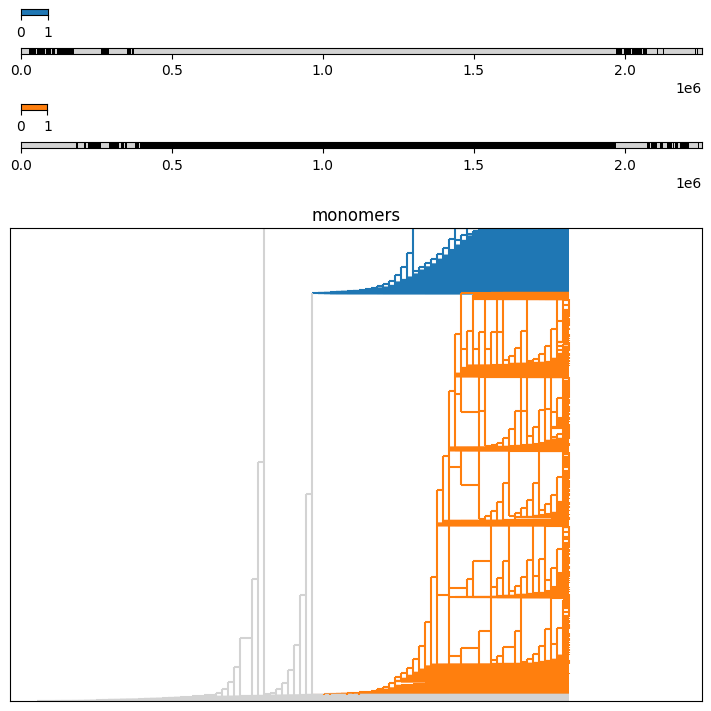

Subtree: [1]
None


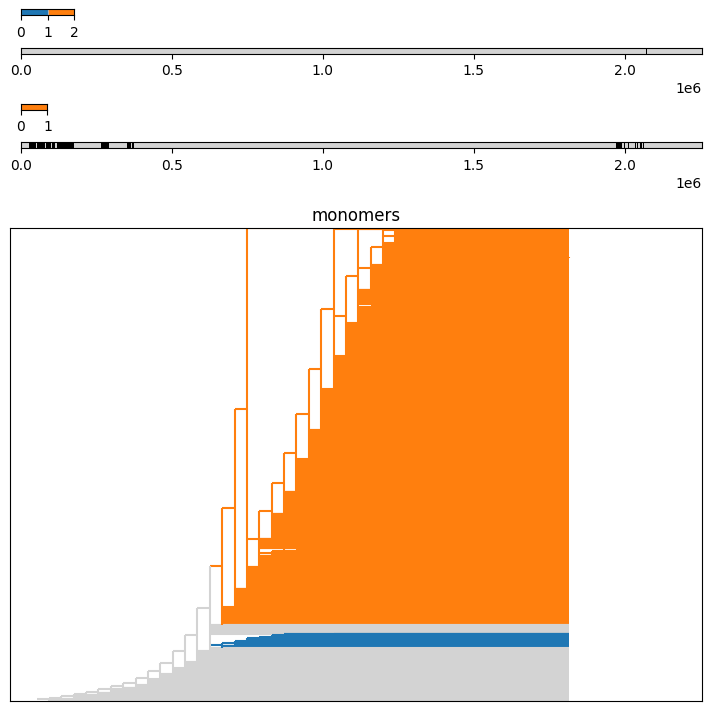

Subtree: [2]
None


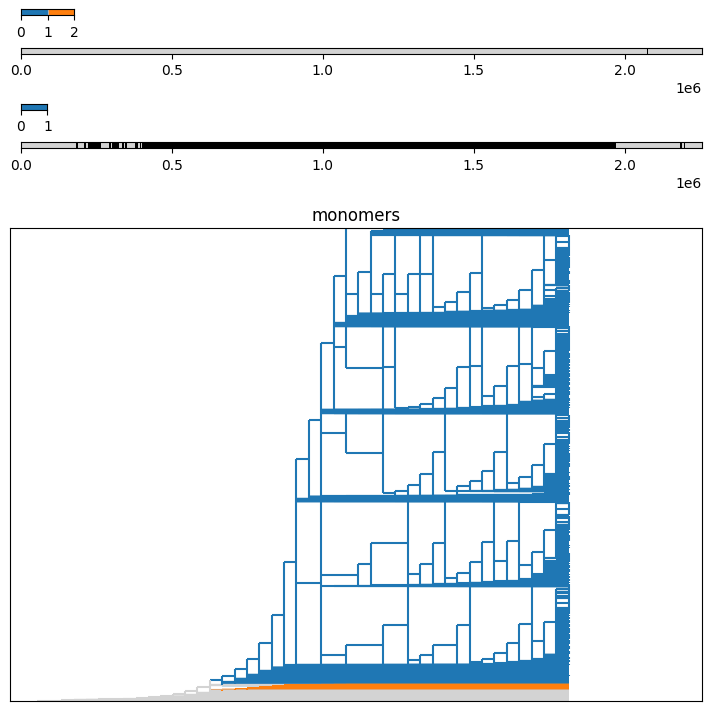

Subtree: [2, 2]
None


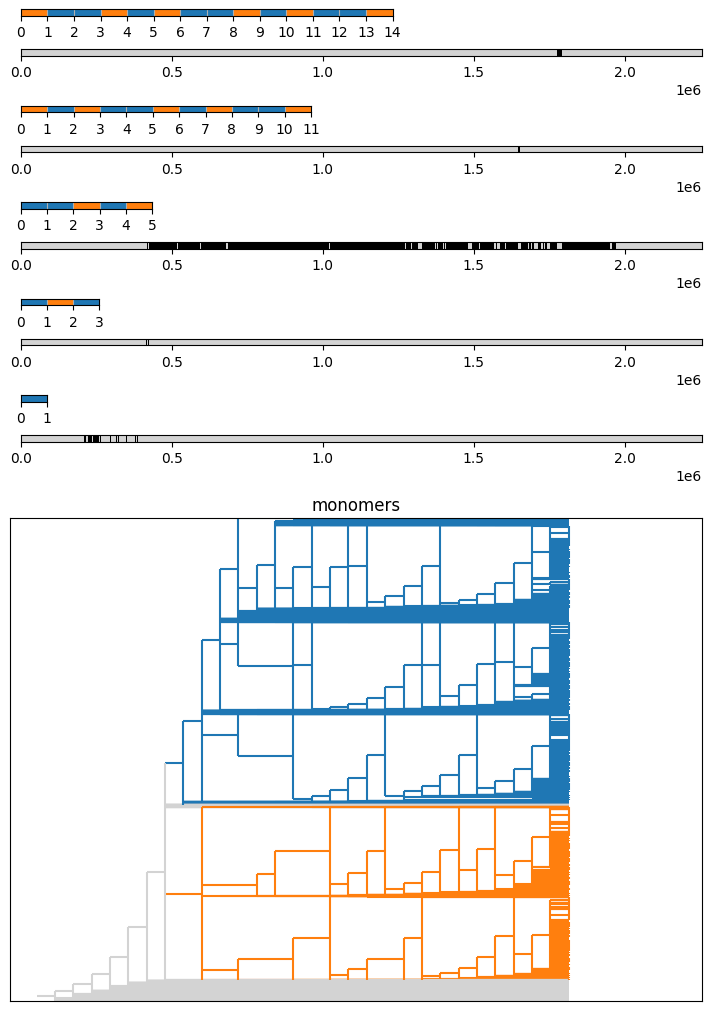

Subtree: [2, 2, 1]
None


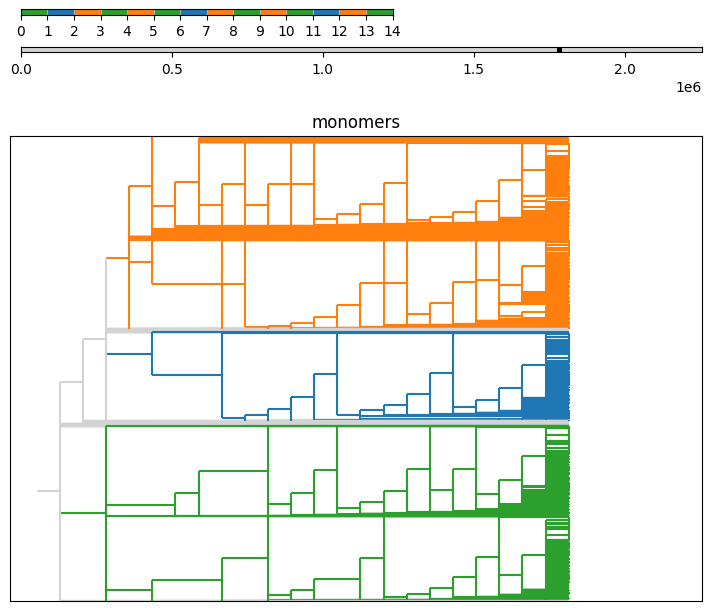

Subtree: [2, 2, 1, 1]
None


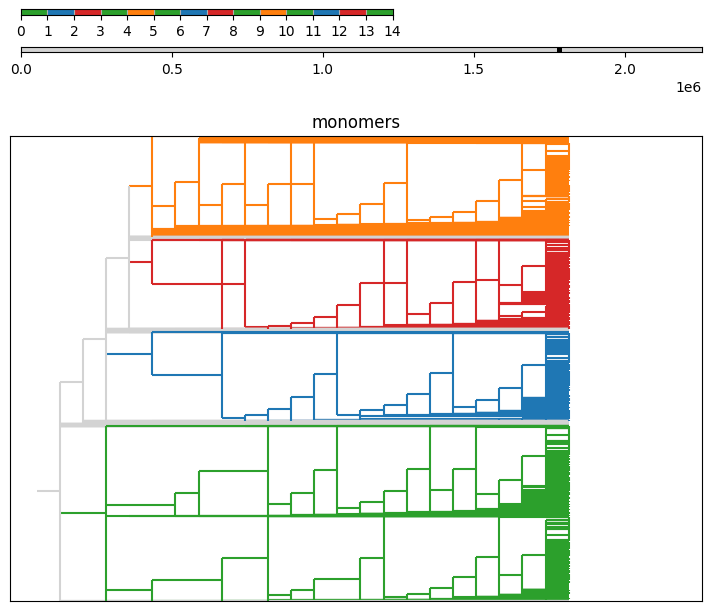

Subtree: [2, 2, 1, 1, 1]
None


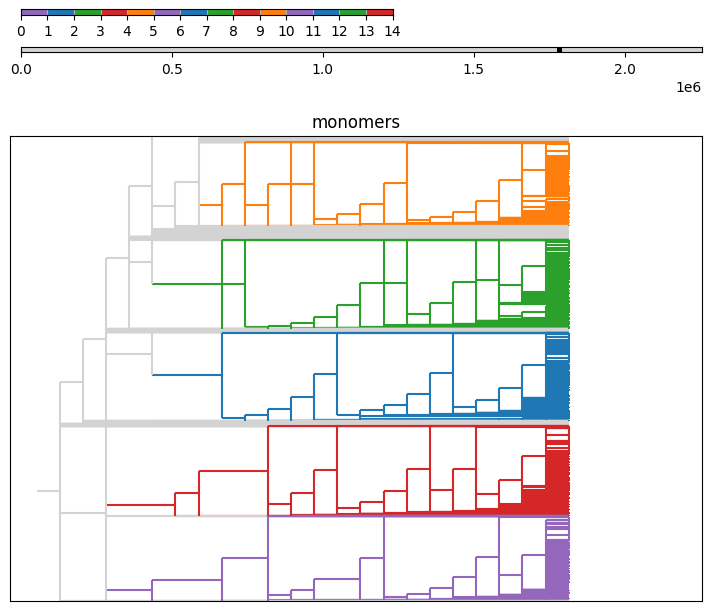

Subtree: [2, 2, 1, 1, 1, 1]
None


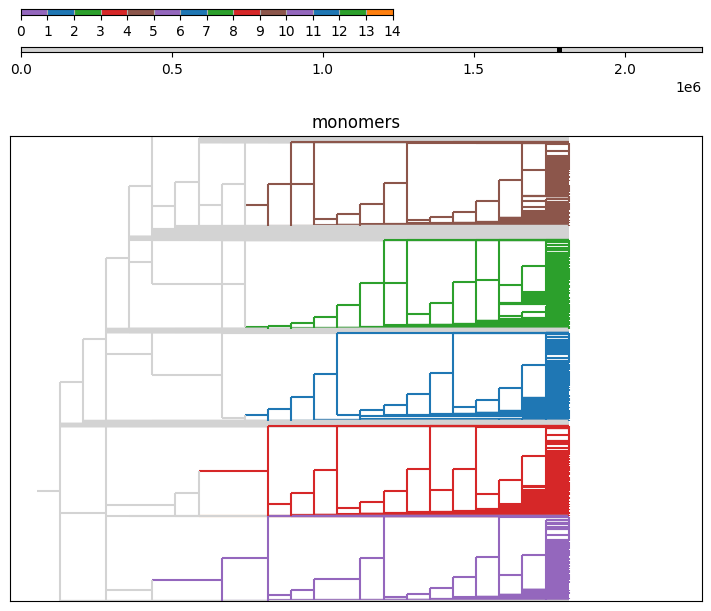

Subtree: [2, 2, 2]
None


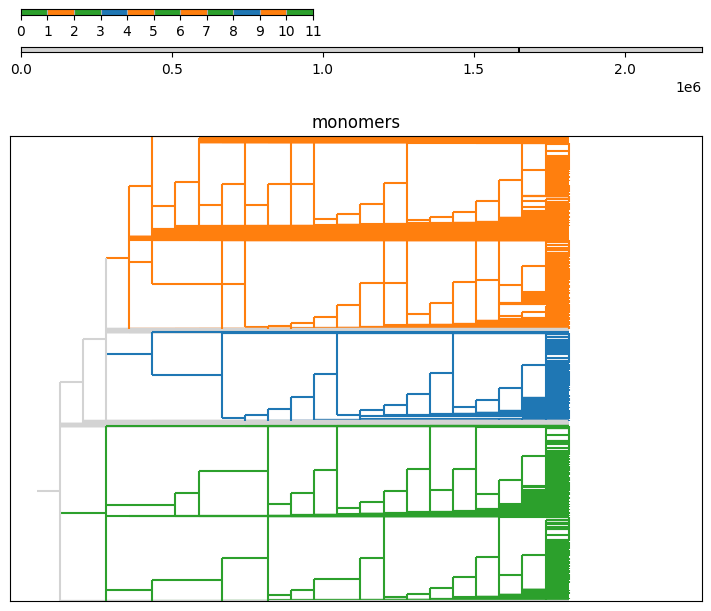

Subtree: [2, 2, 2, 1]
None


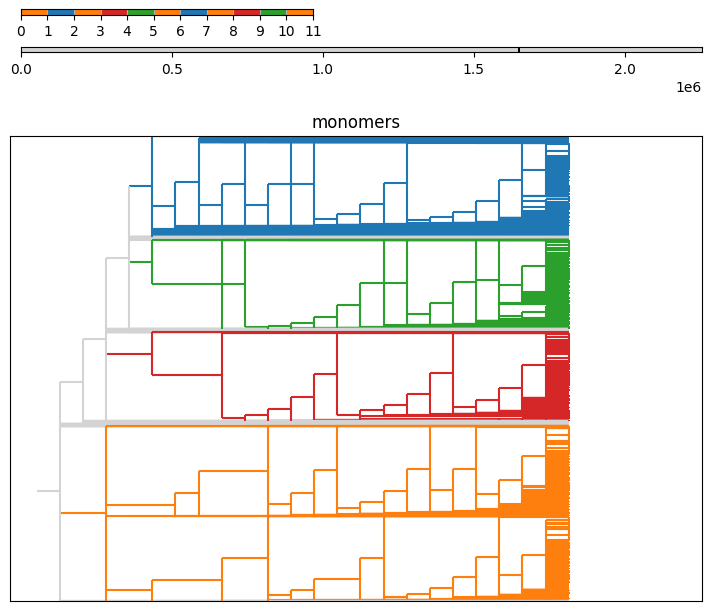

Subtree: [2, 2, 2, 1, 1]
None


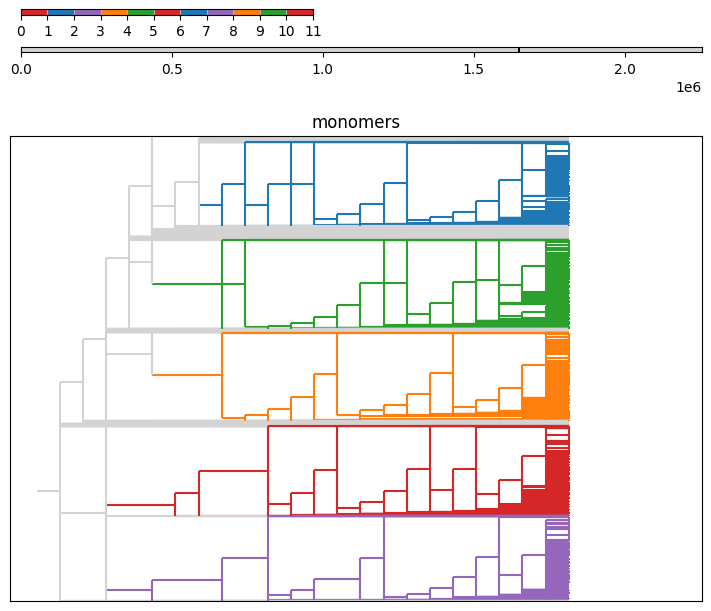

Subtree: [2, 2, 3]
None


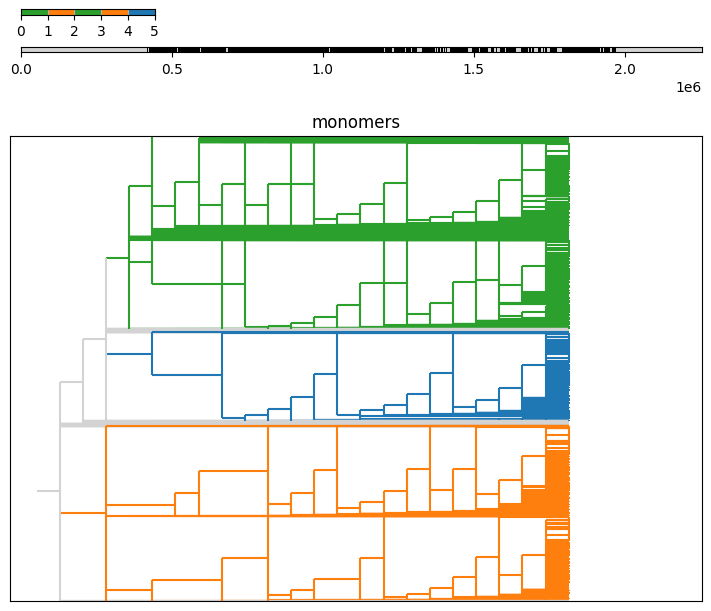

Subtree: [2, 2, 3, 1]
None


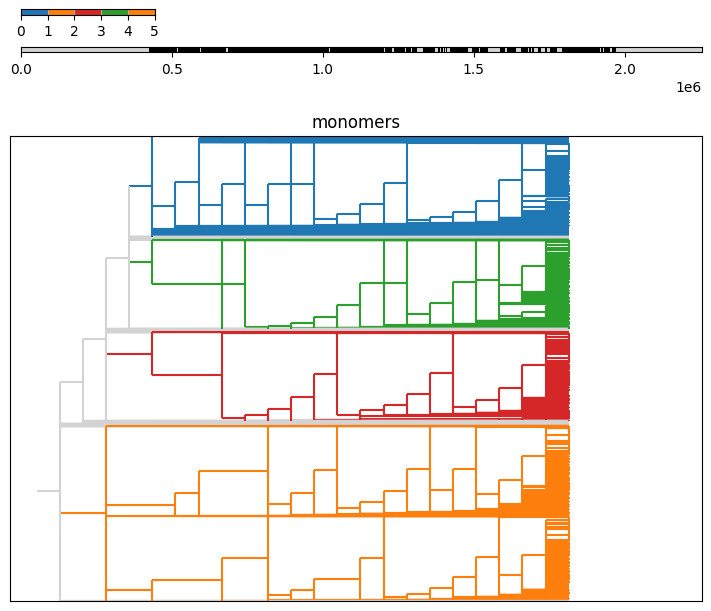

Subtree: [2, 2, 3, 1, 1]
None


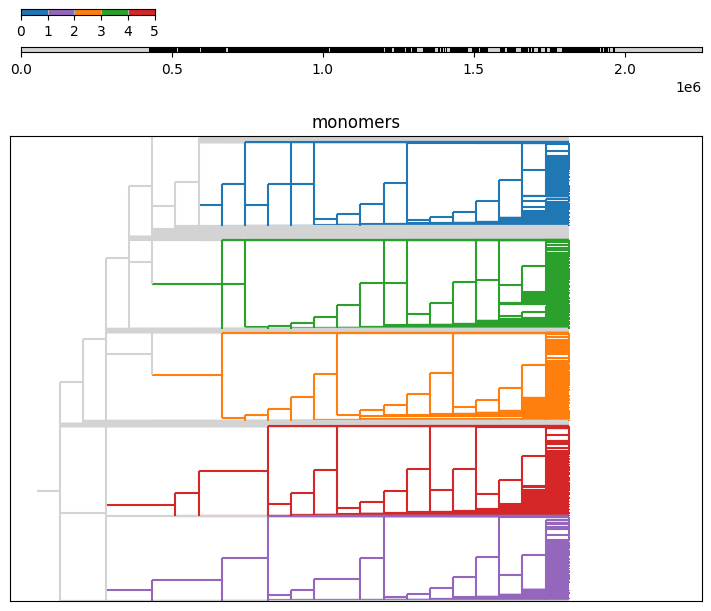

Subtree: [2, 2, 3, 1, 1, 1]
None


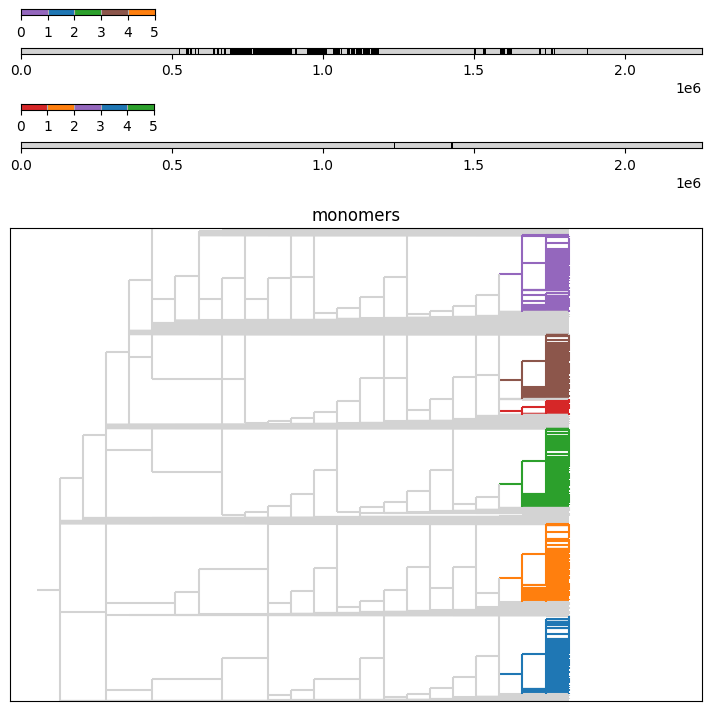

In [ ]:
show_hor_tree(hor_tree_root=hor_tree_root, reference_seq=references['chr4_hap2_hsa5:64806450-67061718'], tree=phylogeny)